# Model 1 - A model which predicts the total daily energy usage based on the provided weather data

# Energy Price and Demand Analysis and Data Preparation 

In [ ]:
import pandas as pd
import numpy as np   
import seaborn as sns
%pip install statsmodels 
import statsmodels.api as statsmodels
import matplotlib.pyplot as plt
%matplotlib inline  

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from statsmodels.tsa.stattools import grangercausalitytests

# Price and Energy Demand Dataset

In [2]:
# Load price data
price = pd.read_csv('price_demand_data.csv')
display(price.head())

,REGION,SETTLEMENTDATE,TOTALDEMAND,PRICECATEGORY
0,VIC1,1/01/2021 0:30,4179.21,LOW
1,VIC1,1/01/2021 1:00,4047.76,LOW
2,VIC1,1/01/2021 1:30,3934.70,LOW
3,VIC1,1/01/2021 2:00,3766.45,LOW
4,VIC1,1/01/2021 2:30,3590.37,LOW


In [3]:
price.describe()

,TOTALDEMAND
count,11664.000000
mean,4925.798454
std,876.407490
min,2708.530000
25%,4255.500000
50%,4803.755000
75%,5477.337500
max,8196.830000


In [4]:
# Check the data information
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11664 entries, 0 to 11663
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   REGION          11664 non-null  object 
 1   SETTLEMENTDATE  11664 non-null  object 
 2   TOTALDEMAND     11664 non-null  float64
 3   PRICECATEGORY   11664 non-null  object 
dtypes: float64(1), object(3)
memory usage: 364.6+ KB


In [5]:
## Detect missing values
price.isna().sum()

REGION            0
SETTLEMENTDATE    0
TOTALDEMAND       0
PRICECATEGORY     0
dtype: int64

In [6]:
# Divide Date & Time into different column
price['Date'] = pd.to_datetime(price['SETTLEMENTDATE'], format='%d/%m/%Y %H:%M').dt.date
price['Time'] = pd.to_datetime(price['SETTLEMENTDATE'], format='%d/%m/%Y %H:%M').dt.time
display(price.head())

,REGION,SETTLEMENTDATE,TOTALDEMAND,PRICECATEGORY,Date,Time
0,VIC1,1/01/2021 0:30,4179.21,LOW,2021-01-01,00:30:00
1,VIC1,1/01/2021 1:00,4047.76,LOW,2021-01-01,01:00:00
2,VIC1,1/01/2021 1:30,3934.70,LOW,2021-01-01,01:30:00
3,VIC1,1/01/2021 2:00,3766.45,LOW,2021-01-01,02:00:00
4,VIC1,1/01/2021 2:30,3590.37,LOW,2021-01-01,02:30:00


In [7]:
# Check time range of the dataset
price['Date'].min(), price['Date'].max()

(datetime.date(2021, 1, 1), datetime.date(2021, 9, 1))

In [8]:
# Calculate daily total demand
sum_price = price.groupby('Date')['TOTALDEMAND'].sum()
sum_price = sum_price.reset_index()
display(sum_price.head())

,Date,TOTALDEMAND
0,2021-01-01,185853.37
1,2021-01-02,197990.13
2,2021-01-03,188742.96
3,2021-01-04,199281.07
4,2021-01-05,207680.91


In [9]:
# Set data as index 
sum_price.set_index('Date',inplace = True)
display(sum_price.head())

,TOTALDEMAND
Date,
2021-01-01,185853.37
2021-01-02,197990.13
2021-01-03,188742.96
2021-01-04,199281.07
2021-01-05,207680.91


In [10]:
sum_price.value_counts()

TOTALDEMAND
299108.95      1
226842.38      1
226540.29      1
226280.11      1
226074.10      1
              ..
246892.28      1
246517.90      1
246353.59      1
245902.68      1
4811.27        1
Length: 244, dtype: int64

In [11]:
sum_price.isna().sum()

TOTALDEMAND    0
dtype: int64

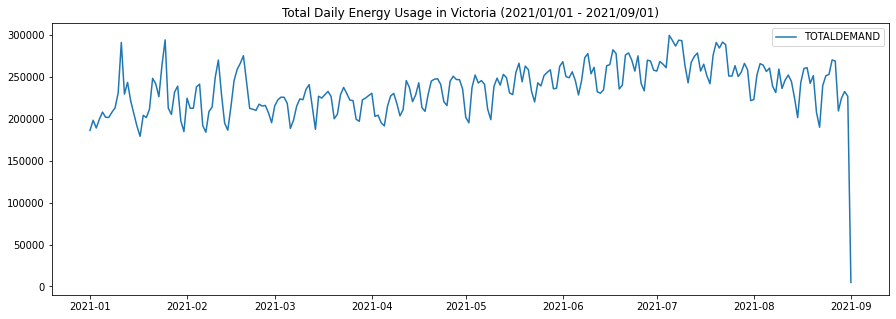

In [12]:
# Plotting Total Daily Energy Demand in Melbourne
fig = plt.figure(figsize=(15,5))
plt.plot(sum_price, label = "TOTALDEMAND")
plt.title("Total Daily Energy Usage in Victoria (2021/01/01 - 2021/09/01)")
plt.legend()
plt.show()

<AxesSubplot:ylabel='Density'>

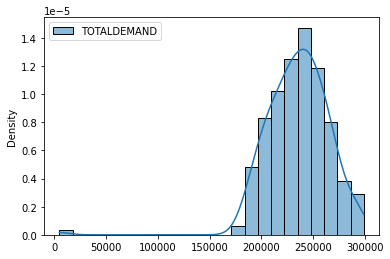

In [13]:
sns.histplot(sum_price, kde=True, stat="density")

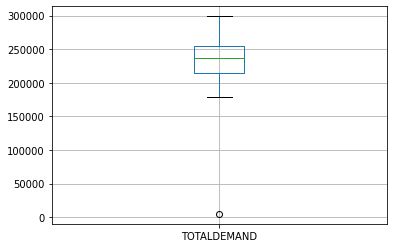

In [14]:
sum_price.boxplot();

## Weather Dataset

In [15]:
# Load in the weather data
weather = pd.read_csv('weather_data.csv')
display(weather.head())

,Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,9am Temperature (°C),...,9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
0,1/01/2021,15.6,29.9,0.0,2.8,9.3,NNE,31.0,13:14,19.2,...,6,N,2,1018.8,28.1,43,5.0,E,13,1015.3
1,2/01/2021,18.4,29.0,0.0,9.4,1.3,NNW,30.0,8:22,23.3,...,7,NNW,17,1013.3,28.7,38,7.0,SW,4,1008.5
2,3/01/2021,17.0,26.2,12.6,4.8,7.1,WSW,33.0,17:55,18.3,...,8,WSW,4,1007.7,23.5,59,4.0,SSW,2,1005.2
3,4/01/2021,16.0,18.6,2.6,3.8,0.0,SSE,41.0,16:03,16.2,...,8,SSE,11,1010.0,18.2,82,8.0,SSW,17,1011.0
4,5/01/2021,15.9,19.1,11.2,1.0,0.0,SSE,35.0,11:02,17.2,...,8,SSE,13,1012.5,18.2,82,8.0,SSE,19,1013.3


In [16]:
weather.describe()

,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Speed of maximum wind gust (km/h),9am Temperature (°C),9am relative humidity (%),9am cloud amount (oktas),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm MSL pressure (hPa)
count,242.000000,242.000000,241.000000,243.000000,243.000000,240.000000,242.000000,242.000000,243.000000,241.000000,243.000000,243.000000,242.000000,242.000000
mean,11.050826,19.445868,1.576763,3.902469,5.349383,34.412500,13.720661,74.454545,5.164609,1017.740664,18.040329,56.930041,5.301653,1015.824793
std,3.870242,5.354085,4.498754,2.702141,3.604902,10.909319,4.306618,14.177593,2.562778,7.683402,4.963547,14.017376,2.392051,7.435859
min,1.700000,10.600000,0.000000,0.000000,0.000000,15.000000,3.000000,25.000000,0.000000,989.700000,8.600000,21.000000,0.000000,989.000000
25%,8.100000,15.500000,0.000000,1.900000,2.150000,28.000000,10.925000,65.000000,3.000000,1012.800000,14.400000,48.000000,3.000000,1011.000000
50%,10.900000,18.300000,0.000000,3.200000,4.900000,33.000000,13.400000,75.000000,7.000000,1018.100000,17.100000,56.000000,7.000000,1015.750000
75%,13.800000,21.800000,0.600000,5.600000,8.350000,41.000000,16.400000,84.000000,7.000000,1023.700000,20.150000,66.000000,7.000000,1021.600000
max,22.200000,39.200000,43.200000,13.800000,13.100000,67.000000,30.900000,100.000000,8.000000,1034.200000,35.200000,98.000000,8.000000,1032.400000


In [17]:
# Check data information
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Date                               243 non-null    object 
 1   Minimum temperature (°C)           242 non-null    float64
 2   Maximum temperature (°C)           242 non-null    float64
 3   Rainfall (mm)                      241 non-null    float64
 4   Evaporation (mm)                   243 non-null    float64
 5   Sunshine (hours)                   243 non-null    float64
 6   Direction of maximum wind gust     240 non-null    object 
 7   Speed of maximum wind gust (km/h)  240 non-null    float64
 8   Time of maximum wind gust          240 non-null    object 
 9   9am Temperature (°C)               242 non-null    float64
 10  9am relative humidity (%)          242 non-null    float64
 11  9am cloud amount (oktas)           243 non-null    int64  

In [18]:
weather['Date'].value_counts()

26/08/2021    1
29/08/2021    1
24/03/2021    1
10/07/2021    1
13/03/2021    1
             ..
4/02/2021     1
12/02/2021    1
15/07/2021    1
16/05/2021    1
30/04/2021    1
Name: Date, Length: 243, dtype: int64

In [19]:
# Reformat the date to be consistant with price_demand dataset
weather['Date'] = pd.to_datetime(weather['Date'], format='%d/%m/%Y').dt.date
display(weather.head())

,Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,9am Temperature (°C),...,9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
0,2021-01-01,15.6,29.9,0.0,2.8,9.3,NNE,31.0,13:14,19.2,...,6,N,2,1018.8,28.1,43,5.0,E,13,1015.3
1,2021-01-02,18.4,29.0,0.0,9.4,1.3,NNW,30.0,8:22,23.3,...,7,NNW,17,1013.3,28.7,38,7.0,SW,4,1008.5
2,2021-01-03,17.0,26.2,12.6,4.8,7.1,WSW,33.0,17:55,18.3,...,8,WSW,4,1007.7,23.5,59,4.0,SSW,2,1005.2
3,2021-01-04,16.0,18.6,2.6,3.8,0.0,SSE,41.0,16:03,16.2,...,8,SSE,11,1010.0,18.2,82,8.0,SSW,17,1011.0
4,2021-01-05,15.9,19.1,11.2,1.0,0.0,SSE,35.0,11:02,17.2,...,8,SSE,13,1012.5,18.2,82,8.0,SSE,19,1013.3


In [20]:
weather['Date'].min(), weather['Date'].max()

(datetime.date(2021, 1, 1), datetime.date(2021, 8, 31))

In [21]:
weather.columns

Index(['Date', 'Minimum temperature (°C)', 'Maximum temperature (°C)',
       'Rainfall (mm)', 'Evaporation (mm)', 'Sunshine (hours)',
       'Direction of maximum wind gust ', 'Speed of maximum wind gust (km/h)',
       'Time of maximum wind gust', '9am Temperature (°C)',
       '9am relative humidity (%)', '9am cloud amount (oktas)',
       '9am wind direction', '9am wind speed (km/h)', '9am MSL pressure (hPa)',
       '3pm Temperature (°C)', '3pm relative humidity (%)',
       '3pm cloud amount (oktas)', '3pm wind direction',
       '3pm wind speed (km/h)', '3pm MSL pressure (hPa)'],
      dtype='object')

In [22]:
weather.set_index('Date', inplace=True)
display(weather.head())

,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,9am Temperature (°C),9am relative humidity (%),9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
Date,,,,,,,,,,,,,,,,,,,,
2021-01-01,15.6,29.9,0.0,2.8,9.3,NNE,31.0,13:14,19.2,77.0,6,N,2,1018.8,28.1,43,5.0,E,13,1015.3
2021-01-02,18.4,29.0,0.0,9.4,1.3,NNW,30.0,8:22,23.3,52.0,7,NNW,17,1013.3,28.7,38,7.0,SW,4,1008.5
2021-01-03,17.0,26.2,12.6,4.8,7.1,WSW,33.0,17:55,18.3,100.0,8,WSW,4,1007.7,23.5,59,4.0,SSW,2,1005.2
2021-01-04,16.0,18.6,2.6,3.8,0.0,SSE,41.0,16:03,16.2,98.0,8,SSE,11,1010.0,18.2,82,8.0,SSW,17,1011.0
2021-01-05,15.9,19.1,11.2,1.0,0.0,SSE,35.0,11:02,17.2,96.0,8,SSE,13,1012.5,18.2,82,8.0,SSE,19,1013.3


In [23]:
# Detect missing values
weather.isna().sum()

Minimum temperature (°C)             1
Maximum temperature (°C)             1
Rainfall (mm)                        2
Evaporation (mm)                     0
Sunshine (hours)                     0
Direction of maximum wind gust       3
Speed of maximum wind gust (km/h)    3
Time of maximum wind gust            3
9am Temperature (°C)                 1
9am relative humidity (%)            1
9am cloud amount (oktas)             0
9am wind direction                   1
9am wind speed (km/h)                1
9am MSL pressure (hPa)               2
3pm Temperature (°C)                 0
3pm relative humidity (%)            0
3pm cloud amount (oktas)             1
3pm wind direction                   0
3pm wind speed (km/h)                0
3pm MSL pressure (hPa)               1
dtype: int64


In order to merge two datasets, the index in both datasets have to be matched. 
The price demand dataset range from 1/01/2021 to 1/09/2021, while the weather dataset range from 1/01/2021 to 31/08/2021. 
Thus, we will select the same range in the weather dataset.

In [24]:
# Merge price and weather dataset together
all_data = pd.merge(sum_price, weather, how = "right", on = 'Date')
display(all_data.head())

,TOTALDEMAND,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,9am Temperature (°C),...,9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,185853.37,15.6,29.9,0.0,2.8,9.3,NNE,31.0,13:14,19.2,...,6,N,2,1018.8,28.1,43,5.0,E,13,1015.3
2021-01-02,197990.13,18.4,29.0,0.0,9.4,1.3,NNW,30.0,8:22,23.3,...,7,NNW,17,1013.3,28.7,38,7.0,SW,4,1008.5
2021-01-03,188742.96,17.0,26.2,12.6,4.8,7.1,WSW,33.0,17:55,18.3,...,8,WSW,4,1007.7,23.5,59,4.0,SSW,2,1005.2
2021-01-04,199281.07,16.0,18.6,2.6,3.8,0.0,SSE,41.0,16:03,16.2,...,8,SSE,11,1010.0,18.2,82,8.0,SSW,17,1011.0
2021-01-05,207680.91,15.9,19.1,11.2,1.0,0.0,SSE,35.0,11:02,17.2,...,8,SSE,13,1012.5,18.2,82,8.0,SSE,19,1013.3


In [25]:
# Select numerical features for further analysis
simple_data = all_data[['TOTALDEMAND', 'Minimum temperature (°C)', 'Maximum temperature (°C)', 'Rainfall (mm)', 'Evaporation (mm)', 'Sunshine (hours)','Speed of maximum wind gust (km/h)', '9am Temperature (°C)', '9am relative humidity (%)','9am cloud amount (oktas)', '9am wind speed (km/h)', '9am MSL pressure (hPa)', '3pm Temperature (°C)', '3pm relative humidity (%)','3pm cloud amount (oktas)', '3pm wind speed (km/h)', '3pm MSL pressure (hPa)']]
display(simple_data.head())

,TOTALDEMAND,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Speed of maximum wind gust (km/h),9am Temperature (°C),9am relative humidity (%),9am cloud amount (oktas),9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind speed (km/h),3pm MSL pressure (hPa)
Date,,,,,,,,,,,,,,,,,
2021-01-01,185853.37,15.6,29.9,0.0,2.8,9.3,31.0,19.2,77.0,6,2,1018.8,28.1,43,5.0,13,1015.3
2021-01-02,197990.13,18.4,29.0,0.0,9.4,1.3,30.0,23.3,52.0,7,17,1013.3,28.7,38,7.0,4,1008.5
2021-01-03,188742.96,17.0,26.2,12.6,4.8,7.1,33.0,18.3,100.0,8,4,1007.7,23.5,59,4.0,2,1005.2
2021-01-04,199281.07,16.0,18.6,2.6,3.8,0.0,41.0,16.2,98.0,8,11,1010.0,18.2,82,8.0,17,1011.0
2021-01-05,207680.91,15.9,19.1,11.2,1.0,0.0,35.0,17.2,96.0,8,13,1012.5,18.2,82,8.0,19,1013.3


In [26]:
simple_data.describe()

,TOTALDEMAND,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Speed of maximum wind gust (km/h),9am Temperature (°C),9am relative humidity (%),9am cloud amount (oktas),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm MSL pressure (hPa)
count,243.000000,242.000000,242.000000,241.000000,243.000000,243.000000,240.000000,242.000000,242.000000,243.000000,241.000000,243.000000,243.000000,242.000000,242.000000
mean,236418.526337,11.050826,19.445868,1.576763,3.902469,5.349383,34.412500,13.720661,74.454545,5.164609,1017.740664,18.040329,56.930041,5.301653,1015.824793
std,26455.737253,3.870242,5.354085,4.498754,2.702141,3.604902,10.909319,4.306618,14.177593,2.562778,7.683402,4.963547,14.017376,2.392051,7.435859
min,178847.380000,1.700000,10.600000,0.000000,0.000000,0.000000,15.000000,3.000000,25.000000,0.000000,989.700000,8.600000,21.000000,0.000000,989.000000
25%,215330.110000,8.100000,15.500000,0.000000,1.900000,2.150000,28.000000,10.925000,65.000000,3.000000,1012.800000,14.400000,48.000000,3.000000,1011.000000
50%,237119.330000,10.900000,18.300000,0.000000,3.200000,4.900000,33.000000,13.400000,75.000000,7.000000,1018.100000,17.100000,56.000000,7.000000,1015.750000
75%,255493.120000,13.800000,21.800000,0.600000,5.600000,8.350000,41.000000,16.400000,84.000000,7.000000,1023.700000,20.150000,66.000000,7.000000,1021.600000
max,299108.950000,22.200000,39.200000,43.200000,13.800000,13.100000,67.000000,30.900000,100.000000,8.000000,1034.200000,35.200000,98.000000,8.000000,1032.400000


In [27]:
simple_data.value_counts()

TOTALDEMAND  Minimum temperature (°C)  Maximum temperature (°C)  Rainfall (mm)  Evaporation (mm)  Sunshine (hours)  Speed of maximum wind gust (km/h)  9am Temperature (°C)  9am relative humidity (%)  9am cloud amount (oktas)  9am wind speed (km/h)  9am MSL pressure (hPa)  3pm Temperature (°C)  3pm relative humidity (%)  3pm cloud amount (oktas)  3pm wind speed (km/h)  3pm MSL pressure (hPa)
299108.95    4.6                       13.1                      0.4            1.6               1.9               22.0                               6.8                   82.0                       7                         9                      1022.7                  12.7                  66                         7.0                       7                      1021.5                    1
222304.88    13.8                      18.2                      1.0            2.8               8.0               35.0                               15.4                  73.0                       7      

In [28]:
simple_data.isna().sum()

TOTALDEMAND                          0
Minimum temperature (°C)             1
Maximum temperature (°C)             1
Rainfall (mm)                        2
Evaporation (mm)                     0
Sunshine (hours)                     0
Speed of maximum wind gust (km/h)    3
9am Temperature (°C)                 1
9am relative humidity (%)            1
9am cloud amount (oktas)             0
9am wind speed (km/h)                1
9am MSL pressure (hPa)               2
3pm Temperature (°C)                 0
3pm relative humidity (%)            0
3pm cloud amount (oktas)             1
3pm wind speed (km/h)                0
3pm MSL pressure (hPa)               1
dtype: int64

In [29]:
# Check missing data and data type
simple_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243 entries, 2021-01-01 to 2021-08-31
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   TOTALDEMAND                        243 non-null    float64
 1   Minimum temperature (°C)           242 non-null    float64
 2   Maximum temperature (°C)           242 non-null    float64
 3   Rainfall (mm)                      241 non-null    float64
 4   Evaporation (mm)                   243 non-null    float64
 5   Sunshine (hours)                   243 non-null    float64
 6   Speed of maximum wind gust (km/h)  240 non-null    float64
 7   9am Temperature (°C)               242 non-null    float64
 8   9am relative humidity (%)          242 non-null    float64
 9   9am cloud amount (oktas)           243 non-null    int64  
 10  9am wind speed (km/h)              242 non-null    object 
 11  9am MSL pressure (hPa)             241 non-null

In [30]:
# Replace 'Calm' to 0
simple_data = simple_data.replace('Calm', '0', regex=True)

In [31]:
# Convert object data type to numeric
simple_data ['9am wind speed (km/h)'] = pd.to_numeric(simple_data['9am wind speed (km/h)'])
simple_data ['3pm wind speed (km/h)'] = pd.to_numeric(simple_data['3pm wind speed (km/h)'])

In [32]:
# Replace Blank Values with NaN
simple_data.replace(np.nan, 0)

# Replace NaN values by mean of each column
simple_data.fillna(simple_data.mean(), inplace=True)

In [33]:
# Check Again - missing data and data type
simple_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243 entries, 2021-01-01 to 2021-08-31
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   TOTALDEMAND                        243 non-null    float64
 1   Minimum temperature (°C)           243 non-null    float64
 2   Maximum temperature (°C)           243 non-null    float64
 3   Rainfall (mm)                      243 non-null    float64
 4   Evaporation (mm)                   243 non-null    float64
 5   Sunshine (hours)                   243 non-null    float64
 6   Speed of maximum wind gust (km/h)  243 non-null    float64
 7   9am Temperature (°C)               243 non-null    float64
 8   9am relative humidity (%)          243 non-null    float64
 9   9am cloud amount (oktas)           243 non-null    int64  
 10  9am wind speed (km/h)              243 non-null    float64
 11  9am MSL pressure (hPa)             243 non-null

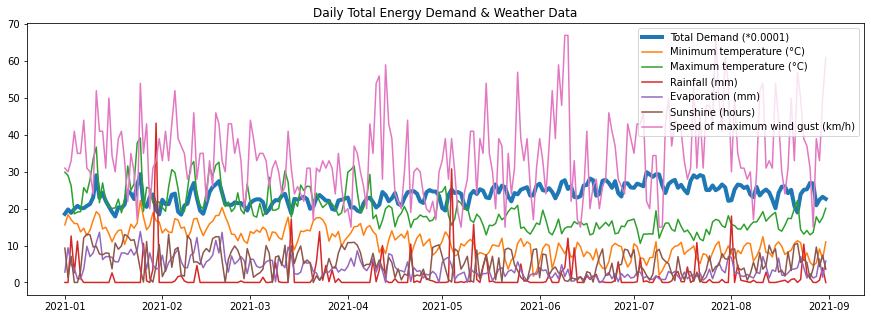

In [34]:
# Plotting selected features for Melbourne between January and August 2021
daily_demand = simple_data['TOTALDEMAND'] * 0.0001 
min_temp = simple_data['Minimum temperature (°C)']
max_temp = simple_data['Maximum temperature (°C)']
rainfall = simple_data['Rainfall (mm)']
evaporation = simple_data['Evaporation (mm)']
sunshine = simple_data['Sunshine (hours)']
speed_of_maximum_wind_gust = simple_data['Speed of maximum wind gust (km/h)']

fig = plt.figure(figsize=(15,5))
plt.plot(daily_demand, label = "Total Demand (*0.0001)", linewidth = 4)
plt.plot(min_temp, label = "Minimum temperature (°C)")
plt.plot(max_temp, label = "Maximum temperature (°C)")
plt.plot(rainfall, label = "Rainfall (mm)")
plt.plot(evaporation, label = "Evaporation (mm)")
plt.plot(sunshine, label = "Sunshine (hours)")
plt.plot(speed_of_maximum_wind_gust, label = "Speed of maximum wind gust (km/h)")
plt.title("Daily Total Energy Demand & Weather Data")
plt.legend(loc='upper right')
plt.show()

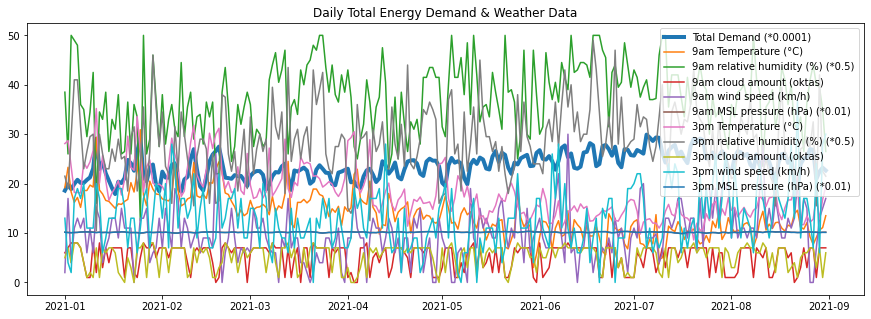

In [35]:
# Plotting selected features for Melbourne between January and August 2021
daily_demand = simple_data['TOTALDEMAND'] * 0.0001 
am_Temperature = simple_data['9am Temperature (°C)']
am_relative_humidity = simple_data['9am relative humidity (%)'] * 0.5
am_cloud_amount = simple_data['9am cloud amount (oktas)']
am_wind_speed = simple_data['9am wind speed (km/h)' ]
am_MSL_pressure = simple_data['9am MSL pressure (hPa)'] * 0.01
pm_Temperature = simple_data['3pm Temperature (°C)']
pm_relative_humidity = simple_data['3pm relative humidity (%)'] * 0.5
pm_cloud_amount = simple_data['3pm cloud amount (oktas)']
pm_wind_speed = simple_data['3pm wind speed (km/h)'] 
pm_MSL_pressure = simple_data['3pm MSL pressure (hPa)'] * 0.01


fig = plt.figure(figsize=(15,5))
plt.plot(daily_demand, label = "Total Demand (*0.0001)", linewidth = 4)
plt.plot(am_Temperature, label = '9am Temperature (°C)')
plt.plot(am_relative_humidity, label = '9am relative humidity (%) (*0.5)')
plt.plot(am_cloud_amount, label = '9am cloud amount (oktas)')
plt.plot(am_wind_speed, label = '9am wind speed (km/h)')
plt.plot(am_MSL_pressure, label = '9am MSL pressure (hPa) (*0.01)')
plt.plot(pm_Temperature, label = '3pm Temperature (°C)')
plt.plot(pm_relative_humidity, label = '3pm relative humidity (%) (*0.5)')
plt.plot(pm_cloud_amount, label = '3pm cloud amount (oktas)')
plt.plot(pm_wind_speed, label = '3pm wind speed (km/h)')
plt.plot(pm_MSL_pressure, label = '3pm MSL pressure (hPa) (*0.01)')
plt.title("Daily Total Energy Demand & Weather Data")
plt.legend(loc='upper right')
plt.show()

# Feature Selection

We will perform Granger’s causality test, it’s possible to test the relationship between each feature. 
The null hypothesis is that the values of the other features (x) do not cause TOTALDEMAND (y).
If the tested p-value is less than the significance level (we use 0.05), then, we can reject the null hypothesis and indicate that the values of the other features (x) do cause TOTALDEMAND (y).

In [49]:
maxlag=12
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(simple_data, variables = simple_data.columns)

,TOTALDEMAND_x,Minimum temperature (°C)_x,Maximum temperature (°C)_x,Evaporation (mm)_x,Sunshine (hours)_x,9am relative humidity (%)_x,9am cloud amount (oktas)_x,3pm cloud amount (oktas)_x
TOTALDEMAND_y,1.0000,0.0000,0.0000,0.0010,0.0012,0.0023,0.0000,0.0035
Minimum temperature (°C)_y,0.0116,1.0000,0.0000,0.0139,0.0000,0.2189,0.0369,0.0002
Maximum temperature (°C)_y,0.0000,0.0002,1.0000,0.0641,0.0000,0.0066,0.0381,0.0000
Evaporation (mm)_y,0.0111,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
Sunshine (hours)_y,0.0020,0.0007,0.0016,0.0168,1.0000,0.1002,0.0003,0.0141
9am relative humidity (%)_y,0.0275,0.0828,0.0003,0.0462,0.0008,1.0000,0.1094,0.0489
9am cloud amount (oktas)_y,0.0013,0.0530,0.2224,0.2836,0.0178,0.2407,1.0000,0.0000
3pm cloud amount (oktas)_y,0.3254,0.1573,0.0708,0.3777,0.0003,0.0735,0.0248,1.0000


The rows are the response (y) and the columns are the predictor series (x). For example, if we take the P-value 0.0000 in (row 'Minimum temperature (°C)_y', column 'TOTALDEMAND_x'), it refers to the P-value of 'TOTALDEMAND_x' causing 'Minimum temperature (°C)_y'.
Here, we are looking at the first row - TOTALDEMAND as the target variable (y) and the rest of the variables as the predictors (x). 
The P-values for Rainfall (mm)_x, Speed of maximum wind gust (km/h)_x, 9am wind speed (km/h)_x, 9am MSL pressure (hPa)_x, 3pm relative humidity (%)_x,3pm wind speed (km/h)_x and 3pm MSL pressure (hPa)_x are greater than 0.05, which means that the variables in these dataset are not influencing the TOTALDEMAND. 
The P-values for Minimum temperature (°C)_x, Maximum temperature (°C)_x, Evaporation (mm)_x and Sunshine (hours)_x are all less than 0.05, which means that all the variables in the dataset are influencing the total demand of energy. 
Moreover, 9am Temperature (°C)_x and 3pm Temperature (°C)_x have high similarity with Minimum temperature (°C)_x and Maximum temperature (°C)_x.
Hence, we will keep Minimum temperature (°C)_x, Maximum temperature (°C)_x, Evaporation (mm)_x, Sunshine (hours)_x, 9am relative humidity (%)_x, 9am cloud amount (oktas)_x and 3pm cloud amount (oktas)_x, and conduct train-validation-test split next.

In [37]:
## Drop data
simple_data = simple_data.drop(columns=['Rainfall (mm)', 'Speed of maximum wind gust (km/h)','9am Temperature (°C)', 
                                        '9am wind speed (km/h)', '9am MSL pressure (hPa)', '3pm Temperature (°C)',
                                        '3pm relative humidity (%)', '3pm wind speed (km/h)', '3pm MSL pressure (hPa)'])
display(simple_data.head())

,TOTALDEMAND,Minimum temperature (°C),Maximum temperature (°C),Evaporation (mm),Sunshine (hours),9am relative humidity (%),9am cloud amount (oktas),3pm cloud amount (oktas)
Date,,,,,,,,
2021-01-01,185853.37,15.6,29.9,2.8,9.3,77.0,6,5.0
2021-01-02,197990.13,18.4,29.0,9.4,1.3,52.0,7,7.0
2021-01-03,188742.96,17.0,26.2,4.8,7.1,100.0,8,4.0
2021-01-04,199281.07,16.0,18.6,3.8,0.0,98.0,8,8.0
2021-01-05,207680.91,15.9,19.1,1.0,0.0,96.0,8,8.0


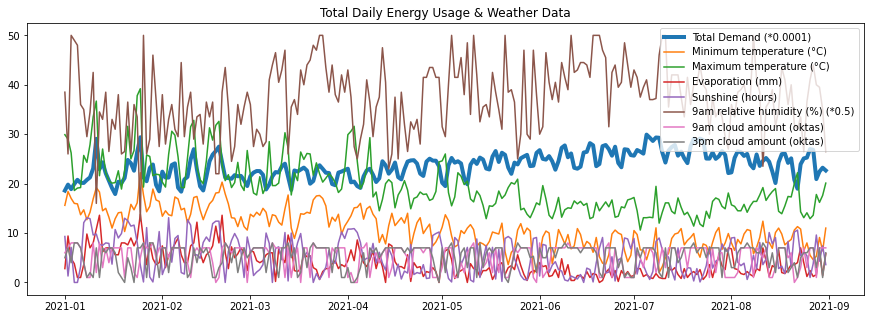

In [38]:
# plotting features that influencing TOTALDEMAND for Melbourne between January and August 2021
daily_demand = simple_data['TOTALDEMAND'] *0.0001 
min_temp = simple_data['Minimum temperature (°C)']
max_temp = simple_data['Maximum temperature (°C)']
evaporation = simple_data['Evaporation (mm)']
sunshine = simple_data['Sunshine (hours)']
am_relative_humidity = simple_data['9am relative humidity (%)'] * 0.5
am_cloud_amount = simple_data['9am cloud amount (oktas)']
pm_cloud_amount = simple_data['3pm cloud amount (oktas)']

fig = plt.figure(figsize=(15,5))
plt.plot(daily_demand, label = "Total Demand (*0.0001)", linewidth = 4)
plt.plot(min_temp, label = "Minimum temperature (°C)")
plt.plot(max_temp, label = "Maximum temperature (°C)")
plt.plot(evaporation, label = "Evaporation (mm)")
plt.plot(sunshine, label = "Sunshine (hours)")
plt.plot(am_relative_humidity, label = '9am relative humidity (%) (*0.5)')
plt.plot(am_cloud_amount, label = '9am cloud amount (oktas)')
plt.plot(pm_cloud_amount, label = '3pm cloud amount (oktas)')
plt.title("Total Daily Energy Usage & Weather Data")
plt.legend()
plt.show()

In [39]:
# Checking correlation - positive or negative correlation
correlation = simple_data.corr()

<AxesSubplot:>

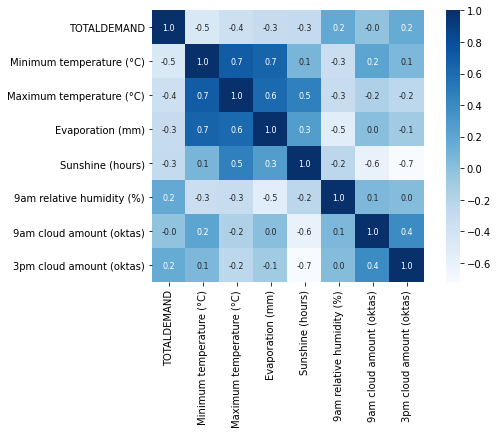

In [40]:
# consruction a heatmap to understand correlation
plt.figure(figsize = (8, 5))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Blues')

In [41]:
# correlation values of TOTALDEMAND
print(correlation['TOTALDEMAND'])

TOTALDEMAND                  1.000000
Minimum temperature (°C)    -0.463628
Maximum temperature (°C)    -0.358718
Evaporation (mm)            -0.297746
Sunshine (hours)            -0.282551
9am relative humidity (%)    0.175374
9am cloud amount (oktas)    -0.016755
3pm cloud amount (oktas)     0.161514
Name: TOTALDEMAND, dtype: float64


<AxesSubplot:xlabel='TOTALDEMAND', ylabel='Density'>

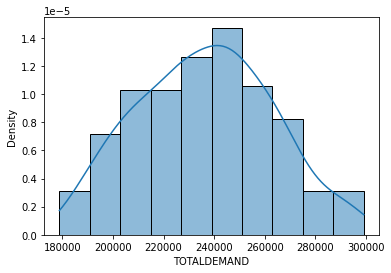

In [42]:
# check data distribition of the TOTALDEMAND
sns.histplot(simple_data['TOTALDEMAND'], kde=True, stat="density")

In [43]:
# Splitting the features and target

# X: features 
X = simple_data.drop(['TOTALDEMAND'], axis=1)

# Y: target
Y = simple_data['TOTALDEMAND']

# Splitting the data into training and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.7, random_state=1)

In [44]:
# Model Training - Random Forest Algorithm
regressor = RandomForestRegressor(n_estimators=200)

In [45]:
# training the model
regressor.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=200)

In [46]:
# Model evaluation
# prediction on Test Data
test_data_prediction = regressor.predict(X_test)
print(test_data_prediction)

[211379.84665 205135.6149  246738.49    216273.2818  215357.36405
 253039.4484  235004.93875 274969.4073  266472.39865 210569.81695
 259045.82455 233439.81135 249405.47285 214507.1597  256714.8019
 246039.08405 259642.3178  206707.83445 208534.75555 247228.9374
 256876.30995 236069.3875  211446.5859  239337.1256  240329.50645
 241059.9492  224641.50525 236148.5604  205599.7557  242916.81665
 260904.464   203915.36655 207592.07225 264585.5551  208357.865
 233039.99365 215868.8779  210129.76095 205588.9197  248708.7638
 243966.57465 227794.788   238915.1559  218992.5164  211499.2313
 224305.9335  217076.24305 213214.7998  213692.05115 222971.07285
 263821.11405 257318.6912  256061.5715  245858.6937  247813.1115
 248039.0158  270028.145   208888.8553  199105.889   265480.239
 252027.23375 245721.4744  274408.84505 222796.21755 219911.89495
 244031.29355 244762.27995 263994.49175 253082.59845 251855.3823
 212484.3098  259355.1483  269051.01315 203627.0995  209451.08945
 242632.77735 250567

In [47]:
# R squared error
error_score = metrics.r2_score(Y_test, test_data_prediction)
print("R squared error: ", error_score)

R squared error:  0.5268531963512284


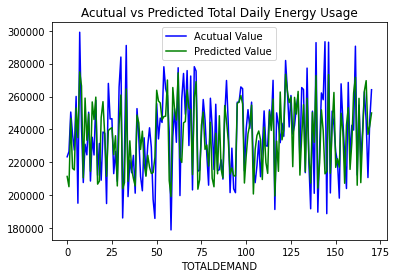

In [48]:
# Compare the Acutual Values and Predicted Values in a Plot

Y_test = list (Y_test)

plt.plot(Y_test, color = 'blue', label = 'Acutual Value')
plt.plot(test_data_prediction, color = 'green', label = 'Predicted Value')
plt.title('Acutual vs Predicted Total Daily Energy Usage')
plt.xlabel('TOTALDEMAND')
plt.legend()
plt.show()